In [8]:
#imports
import os
import torch
import random
import numpy as np
import requests
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import cv2
from tqdm import tqdm
from PIL import Image
from pycocotools.coco import COCO
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt
from torchvision.ops import box_iou, distance_box_iou, complete_box_iou

In [19]:
#Segmentation class inherited from Dr. Kak's DL studio code
class SemanticSegmentationMSE(DLStudio):             
    
    def __init__(self, dl_studio, max_num_objects, dataserver_train=None, dataserver_test=None, dataset_file_train=None, dataset_file_test=None):
        super().__init__()
        self.dl_studio = dl_studio
        self.max_num_objects = max_num_objects
        self.dataserver_train = dataserver_train
        self.dataserver_test = dataserver_test

    
    
    class SkipBlockDN(nn.Module):
        """
        This class for the skip connections in the downward leg of the "U"

        Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockDN
        """
        def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
            super().__init__()
            self.downsample = downsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convo1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
            self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(out_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            if downsample:
                self.downsampler = nn.Conv2d(in_ch, out_ch, 1, stride=2)
        def forward(self, x):
            identity = x                                     
            out = self.convo1(x)                              
            out = self.bn1(out)                              
            out = nn.functional.relu(out)
            if self.in_ch == self.out_ch:
                out = self.convo2(out)                              
                out = self.bn2(out)                              
                out = nn.functional.relu(out)
            if self.downsample:
                out = self.downsampler(out)
                identity = self.downsampler(identity)
            if self.skip_connections:
                if self.in_ch == self.out_ch:
                    out = out + identity
                else:
                    out = out + torch.cat((identity, identity), dim=1) 
            return out


    class SkipBlockUP(nn.Module):
        """
        This class is for the skip connections in the upward leg of the "U"

        Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockUP
        """
        def __init__(self, in_ch, out_ch, upsample=False, skip_connections=True):
            super().__init__()
            self.upsample = upsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convoT1 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
            self.convoT2 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
            self.bn1 = nn.BatchNorm2d(out_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            if upsample:
                self.upsampler = nn.ConvTranspose2d(in_ch, out_ch, 1, stride=2, dilation=2, output_padding=1, padding=0)
        def forward(self, x):
            identity = x                                     
            out = self.convoT1(x)                              
            out = self.bn1(out)                              
            out = nn.functional.relu(out)
            out  =  nn.ReLU(inplace=False)(out)            
            if self.in_ch == self.out_ch:
                out = self.convoT2(out)                              
                out = self.bn2(out)                              
                out = nn.functional.relu(out)
            if self.upsample:
                out = self.upsampler(out)
                identity = self.upsampler(identity)
            if self.skip_connections:
                if self.in_ch == self.out_ch:
                    out = out + identity                              
                else:
                    out = out + identity[:,self.out_ch:,:,:]
            return out


    class mUnet(nn.Module):


        def __init__(self, skip_connections=True, depth=16):
            super().__init__()
            self.depth = depth // 2
            self.conv_in = nn.Conv2d(3, 64, 3, padding=1)
            ##  For the DN arm of the U:
            self.bn1DN  = nn.BatchNorm2d(64)
            self.bn2DN  = nn.BatchNorm2d(128)
            self.skip64DN_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip64DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(64, 64, skip_connections=skip_connections))
            self.skip64dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 64,   downsample=True, skip_connections=skip_connections)
            self.skip64to128DN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 128, skip_connections=skip_connections )
            self.skip128DN_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip128DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(128, 128, skip_connections=skip_connections))
            self.skip128dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(128,128, downsample=True, skip_connections=skip_connections)
            ##  For the UP arm of the U:
            self.bn1UP  = nn.BatchNorm2d(128)
            self.bn2UP  = nn.BatchNorm2d(64)
            self.skip64UP_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip64UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, skip_connections=skip_connections))
            self.skip64usUP = DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, upsample=True, skip_connections=skip_connections)
            self.skip128to64UP = DLStudio.SemanticSegmentation.SkipBlockUP(128, 64, skip_connections=skip_connections )
            self.skip128UP_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip128UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(128, 128, skip_connections=skip_connections))
            self.skip128usUP = DLStudio.SemanticSegmentation.SkipBlockUP(128,128, upsample=True, skip_connections=skip_connections)
            self.conv_out = nn.ConvTranspose2d(64, 5, 3, stride=2,dilation=2,output_padding=1,padding=2)

        def forward(self, x):
            ##  Going down to the bottom of the U:
            x = nn.MaxPool2d(2,2)(nn.functional.relu(self.conv_in(x)))          
            for i,skip64 in enumerate(self.skip64DN_arr[:self.depth//4]):
                x = skip64(x)                

            num_channels_to_save1 = x.shape[1] // 2
            save_for_upside_1 = x[:,:num_channels_to_save1,:,:].clone()
            x = self.skip64dsDN(x)
            for i,skip64 in enumerate(self.skip64DN_arr[self.depth//4:]):
                x = skip64(x)                
            x = self.bn1DN(x)
            num_channels_to_save2 = x.shape[1] // 2
            save_for_upside_2 = x[:,:num_channels_to_save2,:,:].clone()
            x = self.skip64to128DN(x)
            for i,skip128 in enumerate(self.skip128DN_arr[:self.depth//4]):
                x = skip128(x)                

            x = self.bn2DN(x)
            num_channels_to_save3 = x.shape[1] // 2
            save_for_upside_3 = x[:,:num_channels_to_save3,:,:].clone()
            for i,skip128 in enumerate(self.skip128DN_arr[self.depth//4:]):
                x = skip128(x)                
            x = self.skip128dsDN(x)
            ## Coming up from the bottom of U on the other side:
            x = self.skip128usUP(x)          
            for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                x = skip128(x)                
            x[:,:num_channels_to_save3,:,:] =  save_for_upside_3
            x = self.bn1UP(x)
            for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                x = skip128(x)                
            x = self.skip128to64UP(x)
            for i,skip64 in enumerate(self.skip64UP_arr[self.depth//4:]):
                x = skip64(x)                
            x[:,:num_channels_to_save2,:,:] =  save_for_upside_2
            x = self.bn2UP(x)
            x = self.skip64usUP(x)
            for i,skip64 in enumerate(self.skip64UP_arr[:self.depth//4]):
                x = skip64(x)                
            x[:,:num_channels_to_save1,:,:] =  save_for_upside_1
            x = self.conv_out(x)
            return x
    def load_PurdueShapes5MultiObject_dataset(self, dataserver_train, dataserver_test ):   
        self.train_dataloader = torch.utils.data.DataLoader(dataserver_train,
                    batch_size=self.dl_studio.batch_size,shuffle=True, num_workers=4)
        self.test_dataloader = torch.utils.data.DataLoader(dataserver_test,
                           batch_size=self.dl_studio.batch_size,shuffle=False, num_workers=4)

    class SegmentationLoss(nn.Module):
        """
        I wrote this class before I switched to MSE loss.  I am leaving it here
        in case I need to get back to it in the future.  

        Class Path:   DLStudio  ->  SemanticSegmentation  ->  SegmentationLoss
        """
        def __init__(self, batch_size):
            super().__init__()
            self.batch_size = batch_size
        def forward(self, output, mask_tensor):
            composite_loss = torch.zeros(1,self.batch_size)
            mask_based_loss = torch.zeros(1,5)
            for idx in range(self.batch_size):
                outputh = output[idx,0,:,:]
                for mask_layer_idx in range(mask_tensor.shape[0]):
                    mask = mask_tensor[idx,mask_layer_idx,:,:]
                    element_wise = (outputh - mask)**2                   
                    mask_based_loss[0,mask_layer_idx] = torch.mean(element_wise)
                composite_loss[0,idx] = torch.sum(mask_based_loss)
            return torch.sum(composite_loss) / self.batch_size


    def run_code_for_training_for_semantic_segmentation(self, net):        
        filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
        FILE1 = open(filename_for_out1, 'w')
        net = copy.deepcopy(net)
        net = net.to(self.dl_studio.device)
        criterion1 = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), 
                     lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
        start_time = time.perf_counter()
        
        loss_values = []
        for epoch in range(self.dl_studio.epochs):  
            print("")
            running_loss_segmentation = 0.0
            for i, data in enumerate(self.train_dataloader):    
                im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                im_tensor   = im_tensor.to(self.dl_studio.device)
                mask_tensor = mask_tensor.type(torch.FloatTensor)
                mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                optimizer.zero_grad()
                output = net(im_tensor) 
                segmentation_loss = criterion1(output, mask_tensor)  
                segmentation_loss.backward()
                optimizer.step()
                running_loss_segmentation += segmentation_loss.item()    
                if i%100==99:    
                    current_time = time.perf_counter()
                    elapsed_time = current_time - start_time
                    avg_loss_segmentation = running_loss_segmentation / float(100)
                    print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]   MSE loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                    FILE1.write("%.3f\n" % avg_loss_segmentation)
                    FILE1.flush()
                    running_loss_segmentation = 0.0
                    
                    loss_values.append(avg_loss_segmentation)
                    
        print("\nFinished Training\n")
        self.save_model(net)
            # Plot loss values versus iterations
        import matplotlib.pyplot as plt
        plt.plot(range(len(loss_values)), loss_values)
        plt.xlabel('Iterations')
        plt.ylabel('MSE Loss')
        plt.title('Training Loss')
        plt.show()
        return loss_values

    def save_model(self, model):
        '''
        Save the trained model to a disk file
        '''
        torch.save(model.state_dict(), self.dl_studio.path_saved_model)
    def run_code_for_testing_semantic_segmentation(self, net):
        net.load_state_dict(torch.load(self.dl_studio.path_saved_model))
        batch_size = self.dl_studio.batch_size
        image_size = self.dl_studio.image_size
        max_num_objects = self.max_num_objects
        with torch.no_grad():
            for i, data in enumerate(self.test_dataloader):
                im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                if i % 50 == 0:
                    print("\n\n\n\nShowing output for test batch %d: " % (i+1))
                    outputs = net(im_tensor)                        
                    ## In the statement below: 1st arg for batch items, 2nd for channels, 3rd and 4th for image size
                    output_bw_tensor = torch.zeros(batch_size,1,image_size[0],image_size[1], dtype=float)
                    for image_idx in range(batch_size):
                        for layer_idx in range(max_num_objects): 
                            for m in range(image_size[0]):
                                for n in range(image_size[1]):
                                    output_bw_tensor[image_idx,0,m,n]  =  torch.max( outputs[image_idx,:,m,n] )
                    display_tensor = torch.zeros(7 * batch_size,3,image_size[0],image_size[1], dtype=float)
                    for idx in range(batch_size):
                        for bbox_idx in range(max_num_objects):   
                            bb_tensor = bbox_tensor[idx,bbox_idx]
                            for k in range(max_num_objects):
                                i1 = int(bb_tensor[k][1])
                                i2 = int(bb_tensor[k][3])
                                j1 = int(bb_tensor[k][0])
                                j2 = int(bb_tensor[k][2])
                                output_bw_tensor[idx,0,i1:i2,j1] = 255
                                output_bw_tensor[idx,0,i1:i2,j2] = 255
                                output_bw_tensor[idx,0,i1,j1:j2] = 255
                                output_bw_tensor[idx,0,i2,j1:j2] = 255
                                im_tensor[idx,0,i1:i2,j1] = 255
                                im_tensor[idx,0,i1:i2,j2] = 255
                                im_tensor[idx,0,i1,j1:j2] = 255
                                im_tensor[idx,0,i2,j1:j2] = 255
                    display_tensor[:batch_size,:,:,:] = output_bw_tensor
                    display_tensor[batch_size:2*batch_size,:,:,:] = im_tensor

                    for batch_im_idx in range(batch_size):
                        for mask_layer_idx in range(max_num_objects):
                            for i in range(image_size[0]):
                                for j in range(image_size[1]):
                                    if mask_layer_idx == 0:
                                        if 25 < outputs[batch_im_idx,mask_layer_idx,i,j] < 85:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 1:
                                        if 65 < outputs[batch_im_idx,mask_layer_idx,i,j] < 135:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 2:
                                        if 115 < outputs[batch_im_idx,mask_layer_idx,i,j] < 185:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 3:
                                        if 165 < outputs[batch_im_idx,mask_layer_idx,i,j] < 230:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 4:
                                        if outputs[batch_im_idx,mask_layer_idx,i,j] > 210:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50

                            display_tensor[2*batch_size+batch_size*mask_layer_idx+batch_im_idx,:,:,:]= outputs[batch_im_idx,mask_layer_idx,:,:]
                    self.dl_studio.display_tensor_as_image(
                       torchvision.utils.make_grid(display_tensor, nrow=batch_size, normalize=True, padding=2, pad_value=10))


   


Loading training data from torch saved file


The number of learnable parameters in the model: 6999109


The number of layers in the model: 324



[epoch=1/6, iter= 100  elapsed_time=  3 secs]   MSE loss: 476.700
[epoch=1/6, iter= 200  elapsed_time=  5 secs]   MSE loss: 462.879
[epoch=1/6, iter= 300  elapsed_time=  8 secs]   MSE loss: 433.148
[epoch=1/6, iter= 400  elapsed_time= 11 secs]   MSE loss: 439.470
[epoch=1/6, iter= 500  elapsed_time= 14 secs]   MSE loss: 430.143
[epoch=1/6, iter= 600  elapsed_time= 18 secs]   MSE loss: 416.940
[epoch=1/6, iter= 700  elapsed_time= 21 secs]   MSE loss: 430.291
[epoch=1/6, iter= 800  elapsed_time= 24 secs]   MSE loss: 413.865
[epoch=1/6, iter= 900  elapsed_time= 28 secs]   MSE loss: 412.614
[epoch=1/6, iter=1000  elapsed_time= 30 secs]   MSE loss: 405.935
[epoch=1/6, iter=1100  elapsed_time= 33 secs]   MSE loss: 378.914
[epoch=1/6, iter=1200  elapsed_time= 35 secs]   MSE loss: 384.867
[epoch=1/6, iter=1300  elapsed_time= 39 secs]   MSE loss: 39

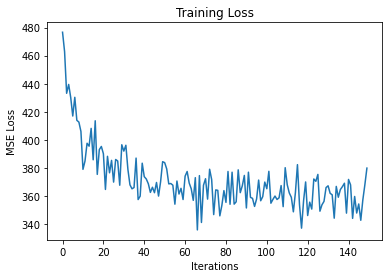

In [17]:
##Code inherited from Dr. Kak's DL studio code

##  semantic_segmentation.py

"""
This script should be your starting point if you wish to learn how to use the
mUnet neural network for semantic segmentation of images.  As mentioned elsewhere in
the main documentation page, mUnet assigns an output channel to each different type of
object that you wish to segment out from an image. So, given a test image at the
input to the network, all you have to do is to examine each channel at the output for
segmenting out the objects that correspond to that output channel.
"""



"""
seed = 0           
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)
"""


##  watch -d -n 0.5 nvidia-smi

from DLStudio import *

dls = DLStudio(

                  dataroot = "/home/skose/dataset/",
                  image_size = [64,64],
                  path_saved_model = "./saved_model_mse",
                  momentum = 0.9,
                  learning_rate = 1e-4,
                  epochs = 6,
                  batch_size = 4,
                  classes = ('rectangle','triangle','disk','oval','star'),
                  use_gpu = True,
              )

segmenter = SemanticSegmentationMSE( 
                  dl_studio = dls, 
                  max_num_objects = 5,
              )

dataserver_train = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                          train_or_test = 'train',
                          dl_studio = dls,
                          segmenter = segmenter,
                          dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                          train_or_test = 'test',
                          dl_studio = dls,
                          segmenter = segmenter,
                          dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test

segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

model = segmenter.mUnet(skip_connections=True, depth=16)
#model = segmenter.mUnet(skip_connections=False, depth=4)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d\n" % number_of_learnable_params)

num_layers = len(list(model.parameters()))
print("\nThe number of layers in the model: %d\n\n" % num_layers)


mse_loss = segmenter.run_code_for_training_for_semantic_segmentation(model)







Showing output for test batch 1: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


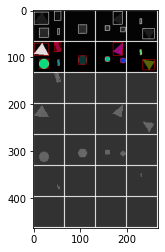





Showing output for test batch 51: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


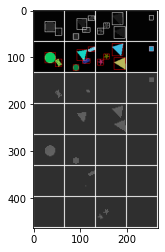





Showing output for test batch 101: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


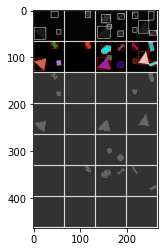





Showing output for test batch 151: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


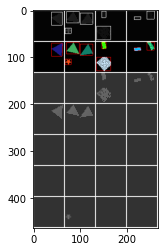





Showing output for test batch 201: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


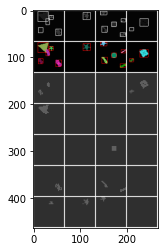

In [56]:
segmenter.run_code_for_testing_semantic_segmentation(model)

In [69]:

mse_loss

[335.70025009155273,
 336.9545347595215,
 341.01404930114745,
 342.57597412109374,
 343.9372497558594,
 344.0738507080078,
 345.7337400436401,
 345.97300453186034,
 346.6366059112549,
 347.66963653564454,
 347.7469376373291,
 348.6073381042481,
 349.0570129394531,
 350.57369987487795,
 351.35869079589844,
 352.2984627151489,
 352.46789352416994,
 353.2438087463379,
 353.6108645629883,
 353.7242065429688,
 353.985652923584,
 354.05727989196777,
 354.096628112793,
 354.2020016479492,
 354.74974609375,
 355.35448959350583,
 355.50496139526365,
 355.7640394592285,
 356.06848220825196,
 356.5042593383789,
 356.5605207824707,
 356.7877047729492,
 357.0625123596191,
 357.36037826538086,
 357.379461517334,
 357.4051081085205,
 357.4860821533203,
 357.66889045715334,
 357.784972076416,
 358.2178536987305,
 358.60799896240235,
 358.9151191711426,
 358.9540657043457,
 359.0162641143799,
 359.4376303100586,
 359.55719921112063,
 359.79118682861326,
 359.83954025268554,
 359.85308349609375,
 360.75

In [14]:
#Segmentation class inherited from Dr. Kak's DL studio code
class SemanticSegmentationDice(DLStudio):             
    
    def __init__(self, dl_studio, max_num_objects, dataserver_train=None, dataserver_test=None, dataset_file_train=None, dataset_file_test=None):
        super().__init__()
        self.dl_studio = dl_studio
        self.max_num_objects = max_num_objects
        self.dataserver_train = dataserver_train
        self.dataserver_test = dataserver_test

    
    
    class SkipBlockDN(nn.Module):
        """
        This class for the skip connections in the downward leg of the "U"

        Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockDN
        """
        def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
            super().__init__()
            self.downsample = downsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convo1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
            self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(out_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            if downsample:
                self.downsampler = nn.Conv2d(in_ch, out_ch, 1, stride=2)
        def forward(self, x):
            identity = x                                     
            out = self.convo1(x)                              
            out = self.bn1(out)                              
            out = nn.functional.relu(out)
            if self.in_ch == self.out_ch:
                out = self.convo2(out)                              
                out = self.bn2(out)                              
                out = nn.functional.relu(out)
            if self.downsample:
                out = self.downsampler(out)
                identity = self.downsampler(identity)
            if self.skip_connections:
                if self.in_ch == self.out_ch:
                    out = out + identity
                else:
                    out = out + torch.cat((identity, identity), dim=1) 
            return out


    class SkipBlockUP(nn.Module):
        """
        This class is for the skip connections in the upward leg of the "U"

        Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockUP
        """
        def __init__(self, in_ch, out_ch, upsample=False, skip_connections=True):
            super().__init__()
            self.upsample = upsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convoT1 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
            self.convoT2 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
            self.bn1 = nn.BatchNorm2d(out_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            if upsample:
                self.upsampler = nn.ConvTranspose2d(in_ch, out_ch, 1, stride=2, dilation=2, output_padding=1, padding=0)
        def forward(self, x):
            identity = x                                     
            out = self.convoT1(x)                              
            out = self.bn1(out)                              
            out = nn.functional.relu(out)
            out  =  nn.ReLU(inplace=False)(out)            
            if self.in_ch == self.out_ch:
                out = self.convoT2(out)                              
                out = self.bn2(out)                              
                out = nn.functional.relu(out)
            if self.upsample:
                out = self.upsampler(out)
                identity = self.upsampler(identity)
            if self.skip_connections:
                if self.in_ch == self.out_ch:
                    out = out + identity                              
                else:
                    out = out + identity[:,self.out_ch:,:,:]
            return out


    class mUnet(nn.Module):


        def __init__(self, skip_connections=True, depth=16):
            super().__init__()
            self.depth = depth // 2
            self.conv_in = nn.Conv2d(3, 64, 3, padding=1)
            ##  For the DN arm of the U:
            self.bn1DN  = nn.BatchNorm2d(64)
            self.bn2DN  = nn.BatchNorm2d(128)
            self.skip64DN_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip64DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(64, 64, skip_connections=skip_connections))
            self.skip64dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 64,   downsample=True, skip_connections=skip_connections)
            self.skip64to128DN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 128, skip_connections=skip_connections )
            self.skip128DN_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip128DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(128, 128, skip_connections=skip_connections))
            self.skip128dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(128,128, downsample=True, skip_connections=skip_connections)
            ##  For the UP arm of the U:
            self.bn1UP  = nn.BatchNorm2d(128)
            self.bn2UP  = nn.BatchNorm2d(64)
            self.skip64UP_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip64UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, skip_connections=skip_connections))
            self.skip64usUP = DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, upsample=True, skip_connections=skip_connections)
            self.skip128to64UP = DLStudio.SemanticSegmentation.SkipBlockUP(128, 64, skip_connections=skip_connections )
            self.skip128UP_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip128UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(128, 128, skip_connections=skip_connections))
            self.skip128usUP = DLStudio.SemanticSegmentation.SkipBlockUP(128,128, upsample=True, skip_connections=skip_connections)
            self.conv_out = nn.ConvTranspose2d(64, 5, 3, stride=2,dilation=2,output_padding=1,padding=2)

        def forward(self, x):
            ##  Going down to the bottom of the U:
            x = nn.MaxPool2d(2,2)(nn.functional.relu(self.conv_in(x)))          
            for i,skip64 in enumerate(self.skip64DN_arr[:self.depth//4]):
                x = skip64(x)                

            num_channels_to_save1 = x.shape[1] // 2
            save_for_upside_1 = x[:,:num_channels_to_save1,:,:].clone()
            x = self.skip64dsDN(x)
            for i,skip64 in enumerate(self.skip64DN_arr[self.depth//4:]):
                x = skip64(x)                
            x = self.bn1DN(x)
            num_channels_to_save2 = x.shape[1] // 2
            save_for_upside_2 = x[:,:num_channels_to_save2,:,:].clone()
            x = self.skip64to128DN(x)
            for i,skip128 in enumerate(self.skip128DN_arr[:self.depth//4]):
                x = skip128(x)                

            x = self.bn2DN(x)
            num_channels_to_save3 = x.shape[1] // 2
            save_for_upside_3 = x[:,:num_channels_to_save3,:,:].clone()
            for i,skip128 in enumerate(self.skip128DN_arr[self.depth//4:]):
                x = skip128(x)                
            x = self.skip128dsDN(x)
            ## Coming up from the bottom of U on the other side:
            x = self.skip128usUP(x)          
            for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                x = skip128(x)                
            x[:,:num_channels_to_save3,:,:] =  save_for_upside_3
            x = self.bn1UP(x)
            for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                x = skip128(x)                
            x = self.skip128to64UP(x)
            for i,skip64 in enumerate(self.skip64UP_arr[self.depth//4:]):
                x = skip64(x)                
            x[:,:num_channels_to_save2,:,:] =  save_for_upside_2
            x = self.bn2UP(x)
            x = self.skip64usUP(x)
            for i,skip64 in enumerate(self.skip64UP_arr[:self.depth//4]):
                x = skip64(x)                
            x[:,:num_channels_to_save1,:,:] =  save_for_upside_1
            x = self.conv_out(x)
            return x
    def load_PurdueShapes5MultiObject_dataset(self, dataserver_train, dataserver_test ):   
        self.train_dataloader = torch.utils.data.DataLoader(dataserver_train,
                    batch_size=self.dl_studio.batch_size,shuffle=True, num_workers=4)
        self.test_dataloader = torch.utils.data.DataLoader(dataserver_test,
                           batch_size=self.dl_studio.batch_size,shuffle=False, num_workers=4)

    class SegmentationLoss(nn.Module):
        """
        I wrote this class before I switched to MSE loss.  I am leaving it here
        in case I need to get back to it in the future.  

        Class Path:   DLStudio  ->  SemanticSegmentation  ->  SegmentationLoss
        """
        def __init__(self, batch_size):
            super().__init__()
            self.batch_size = batch_size
        def forward(self, output, mask_tensor):
            composite_loss = torch.zeros(1,self.batch_size)
            mask_based_loss = torch.zeros(1,5)
            for idx in range(self.batch_size):
                outputh = output[idx,0,:,:]
                for mask_layer_idx in range(mask_tensor.shape[0]):
                    mask = mask_tensor[idx,mask_layer_idx,:,:]
                    element_wise = (outputh - mask)**2                   
                    mask_based_loss[0,mask_layer_idx] = torch.mean(element_wise)
                composite_loss[0,idx] = torch.sum(mask_based_loss)
            return torch.sum(composite_loss) / self.batch_size


    def run_code_for_training_for_semantic_segmentation(self, net):        
        filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
        FILE1 = open(filename_for_out1, 'w')
        net = copy.deepcopy(net)
        net = net.to(self.dl_studio.device)

        optimizer = optim.SGD(net.parameters(), 
                     lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
        start_time = time.perf_counter()
        
        loss_values = []
        for epoch in range(self.dl_studio.epochs):  
            print("")
            running_loss_segmentation_dice = 0.0
            for i, data in enumerate(self.train_dataloader):    
                im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                im_tensor   = im_tensor.to(self.dl_studio.device)
                mask_tensor = mask_tensor.type(torch.FloatTensor)
                mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                optimizer.zero_grad()
                output = net(im_tensor) 
                
                #calculation of Dice Loss:
                numerator = torch.sum(output * mask_tensor)
                denominator = torch.sum(output * output) + torch.sum(mask_tensor * mask_tensor)
                dice_coefficient = 2 * numerator / (denominator + (1e-6))
                segmentation_loss_dice = (1 - dice_coefficient)
                
                
                segmentation_loss_dice.backward()
                optimizer.step()
                running_loss_segmentation_dice += segmentation_loss_dice.item()

                if i%100==99:    
                    current_time = time.perf_counter()
                    elapsed_time = current_time - start_time
                    avg_loss_segmentation = running_loss_segmentation_dice / float(100)
                    print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]   Dice loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                    FILE1.write("%.3f\n" % avg_loss_segmentation)
                    FILE1.flush()
                    running_loss_segmentation_dice = 0.0
                    
                    loss_values.append(avg_loss_segmentation)
                    
        print("\nFinished Training\n")
        self.save_model(net)
            # Plot loss values versus iterations
        import matplotlib.pyplot as plt
        plt.plot(range(len(loss_values)), loss_values)
        plt.xlabel('Iterations')
        plt.ylabel('Dice Loss')
        plt.title('Training Loss')
        plt.show()
        return loss_values

    def save_model(self, model):
        '''
        Save the trained model to a disk file
        '''
        torch.save(model.state_dict(), self.dl_studio.path_saved_model)

    def run_code_for_testing_semantic_segmentation(self, net):
        net.load_state_dict(torch.load(self.dl_studio.path_saved_model))
        batch_size = self.dl_studio.batch_size
        image_size = self.dl_studio.image_size
        max_num_objects = self.max_num_objects
        with torch.no_grad():
            for i, data in enumerate(self.test_dataloader):
                im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                if i % 50 == 0:
                    print("\n\n\n\nShowing output for test batch %d: " % (i+1))
                    outputs = net(im_tensor)                        
                    ## In the statement below: 1st arg for batch items, 2nd for channels, 3rd and 4th for image size
                    output_bw_tensor = torch.zeros(batch_size,1,image_size[0],image_size[1], dtype=float)
                    for image_idx in range(batch_size):
                        for layer_idx in range(max_num_objects): 
                            for m in range(image_size[0]):
                                for n in range(image_size[1]):
                                    output_bw_tensor[image_idx,0,m,n]  =  torch.max( outputs[image_idx,:,m,n] )
                    display_tensor = torch.zeros(7 * batch_size,3,image_size[0],image_size[1], dtype=float)
                    for idx in range(batch_size):
                        for bbox_idx in range(max_num_objects):   
                            bb_tensor = bbox_tensor[idx,bbox_idx]
                            for k in range(max_num_objects):
                                i1 = int(bb_tensor[k][1])
                                i2 = int(bb_tensor[k][3])
                                j1 = int(bb_tensor[k][0])
                                j2 = int(bb_tensor[k][2])
                                output_bw_tensor[idx,0,i1:i2,j1] = 255
                                output_bw_tensor[idx,0,i1:i2,j2] = 255
                                output_bw_tensor[idx,0,i1,j1:j2] = 255
                                output_bw_tensor[idx,0,i2,j1:j2] = 255
                                im_tensor[idx,0,i1:i2,j1] = 255
                                im_tensor[idx,0,i1:i2,j2] = 255
                                im_tensor[idx,0,i1,j1:j2] = 255
                                im_tensor[idx,0,i2,j1:j2] = 255
                    display_tensor[:batch_size,:,:,:] = output_bw_tensor
                    display_tensor[batch_size:2*batch_size,:,:,:] = im_tensor

                    for batch_im_idx in range(batch_size):
                        for mask_layer_idx in range(max_num_objects):
                            for i in range(image_size[0]):
                                for j in range(image_size[1]):
                                    if mask_layer_idx == 0:
                                        if 25 < outputs[batch_im_idx,mask_layer_idx,i,j] < 85:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 1:
                                        if 65 < outputs[batch_im_idx,mask_layer_idx,i,j] < 135:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 2:
                                        if 115 < outputs[batch_im_idx,mask_layer_idx,i,j] < 185:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 3:
                                        if 165 < outputs[batch_im_idx,mask_layer_idx,i,j] < 230:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 4:
                                        if outputs[batch_im_idx,mask_layer_idx,i,j] > 210:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50

                            display_tensor[2*batch_size+batch_size*mask_layer_idx+batch_im_idx,:,:,:]= outputs[batch_im_idx,mask_layer_idx,:,:]
                    self.dl_studio.display_tensor_as_image(
                       torchvision.utils.make_grid(display_tensor, nrow=batch_size, normalize=True, padding=2, pad_value=10))



   


Loading training data from torch saved file


The number of learnable parameters in the model: 6999109


The number of layers in the model: 324



[epoch=1/6, iter= 100  elapsed_time=  3 secs]   Dice loss: 0.915
[epoch=1/6, iter= 200  elapsed_time=  6 secs]   Dice loss: 0.873
[epoch=1/6, iter= 300  elapsed_time=  8 secs]   Dice loss: 0.857
[epoch=1/6, iter= 400  elapsed_time= 11 secs]   Dice loss: 0.849
[epoch=1/6, iter= 500  elapsed_time= 13 secs]   Dice loss: 0.847
[epoch=1/6, iter= 600  elapsed_time= 16 secs]   Dice loss: 0.836
[epoch=1/6, iter= 700  elapsed_time= 18 secs]   Dice loss: 0.835
[epoch=1/6, iter= 800  elapsed_time= 21 secs]   Dice loss: 0.833
[epoch=1/6, iter= 900  elapsed_time= 24 secs]   Dice loss: 0.830
[epoch=1/6, iter=1000  elapsed_time= 27 secs]   Dice loss: 0.822
[epoch=1/6, iter=1100  elapsed_time= 29 secs]   Dice loss: 0.825
[epoch=1/6, iter=1200  elapsed_time= 33 secs]   Dice loss: 0.828
[epoch=1/6, iter=1300  elapsed_time= 35 secs]   Dice loss: 0.821
[epoch=

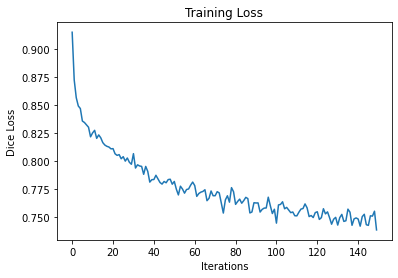

In [15]:
##Code class inherited from Dr. Kak's DL studio code

##  semantic_segmentation.py

"""
This script should be your starting point if you wish to learn how to use the
mUnet neural network for semantic segmentation of images.  As mentioned elsewhere in
the main documentation page, mUnet assigns an output channel to each different type of
object that you wish to segment out from an image. So, given a test image at the
input to the network, all you have to do is to examine each channel at the output for
segmenting out the objects that correspond to that output channel.
"""

"""
seed = 0           
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)
"""


##  watch -d -n 0.5 nvidia-smi

from DLStudio import *

dls = DLStudio(

                  dataroot = "/home/skose/dataset/",
                  image_size = [64,64],
                  path_saved_model = "./saved_model",
                  momentum = 0.9,
                  learning_rate = 1e-4,
                  epochs = 6,
                  batch_size = 4,
                  classes = ('rectangle','triangle','disk','oval','star'),
                  use_gpu = True,
              )

segmenter = SemanticSegmentationDice( 
                  dl_studio = dls, 
                  max_num_objects = 5,
              )

dataserver_train = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                          train_or_test = 'train',
                          dl_studio = dls,
                          segmenter = segmenter,
                          dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                          train_or_test = 'test',
                          dl_studio = dls,
                          segmenter = segmenter,
                          dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test

segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

model = segmenter.mUnet(skip_connections=True, depth=16)
#model = segmenter.mUnet(skip_connections=False, depth=4)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d\n" % number_of_learnable_params)

num_layers = len(list(model.parameters()))
print("\nThe number of layers in the model: %d\n\n" % num_layers)


dice_loss = segmenter.run_code_for_training_for_semantic_segmentation(model)




Loading training data from torch saved file




Showing output for test batch 1: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


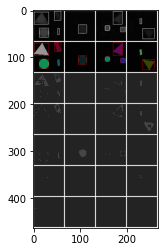





Showing output for test batch 51: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


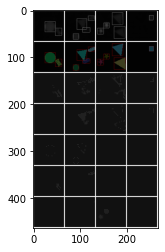





Showing output for test batch 101: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


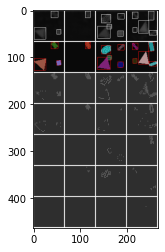





Showing output for test batch 151: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


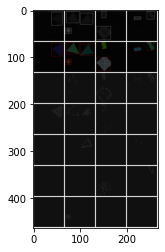





Showing output for test batch 201: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


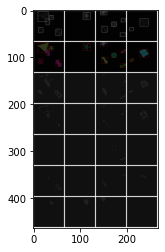

In [53]:
segmenter.run_code_for_testing_semantic_segmentation(model)

In [3]:
#Segmentation class inherited from Dr. Kak's DL studio code
class SemanticSegmentationCombined(DLStudio):             
    
    def __init__(self, dl_studio, max_num_objects, dataserver_train=None, dataserver_test=None, dataset_file_train=None, dataset_file_test=None):
        super().__init__()
        self.dl_studio = dl_studio
        self.max_num_objects = max_num_objects
        self.dataserver_train = dataserver_train
        self.dataserver_test = dataserver_test

    
    
    class SkipBlockDN(nn.Module):
        """
        This class for the skip connections in the downward leg of the "U"

        Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockDN
        """
        def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
            super().__init__()
            self.downsample = downsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convo1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
            self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(out_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            if downsample:
                self.downsampler = nn.Conv2d(in_ch, out_ch, 1, stride=2)
        def forward(self, x):
            identity = x                                     
            out = self.convo1(x)                              
            out = self.bn1(out)                              
            out = nn.functional.relu(out)
            if self.in_ch == self.out_ch:
                out = self.convo2(out)                              
                out = self.bn2(out)                              
                out = nn.functional.relu(out)
            if self.downsample:
                out = self.downsampler(out)
                identity = self.downsampler(identity)
            if self.skip_connections:
                if self.in_ch == self.out_ch:
                    out = out + identity
                else:
                    out = out + torch.cat((identity, identity), dim=1) 
            return out


    class SkipBlockUP(nn.Module):
        """
        This class is for the skip connections in the upward leg of the "U"

        Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockUP
        """
        def __init__(self, in_ch, out_ch, upsample=False, skip_connections=True):
            super().__init__()
            self.upsample = upsample
            self.skip_connections = skip_connections
            self.in_ch = in_ch
            self.out_ch = out_ch
            self.convoT1 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
            self.convoT2 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
            self.bn1 = nn.BatchNorm2d(out_ch)
            self.bn2 = nn.BatchNorm2d(out_ch)
            if upsample:
                self.upsampler = nn.ConvTranspose2d(in_ch, out_ch, 1, stride=2, dilation=2, output_padding=1, padding=0)
        def forward(self, x):
            identity = x                                     
            out = self.convoT1(x)                              
            out = self.bn1(out)                              
            out = nn.functional.relu(out)
            out  =  nn.ReLU(inplace=False)(out)            
            if self.in_ch == self.out_ch:
                out = self.convoT2(out)                              
                out = self.bn2(out)                              
                out = nn.functional.relu(out)
            if self.upsample:
                out = self.upsampler(out)
                identity = self.upsampler(identity)
            if self.skip_connections:
                if self.in_ch == self.out_ch:
                    out = out + identity                              
                else:
                    out = out + identity[:,self.out_ch:,:,:]
            return out


    class mUnet(nn.Module):


        def __init__(self, skip_connections=True, depth=16):
            super().__init__()
            self.depth = depth // 2
            self.conv_in = nn.Conv2d(3, 64, 3, padding=1)
            ##  For the DN arm of the U:
            self.bn1DN  = nn.BatchNorm2d(64)
            self.bn2DN  = nn.BatchNorm2d(128)
            self.skip64DN_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip64DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(64, 64, skip_connections=skip_connections))
            self.skip64dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 64,   downsample=True, skip_connections=skip_connections)
            self.skip64to128DN = DLStudio.SemanticSegmentation.SkipBlockDN(64, 128, skip_connections=skip_connections )
            self.skip128DN_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip128DN_arr.append(DLStudio.SemanticSegmentation.SkipBlockDN(128, 128, skip_connections=skip_connections))
            self.skip128dsDN = DLStudio.SemanticSegmentation.SkipBlockDN(128,128, downsample=True, skip_connections=skip_connections)
            ##  For the UP arm of the U:
            self.bn1UP  = nn.BatchNorm2d(128)
            self.bn2UP  = nn.BatchNorm2d(64)
            self.skip64UP_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip64UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, skip_connections=skip_connections))
            self.skip64usUP = DLStudio.SemanticSegmentation.SkipBlockUP(64, 64, upsample=True, skip_connections=skip_connections)
            self.skip128to64UP = DLStudio.SemanticSegmentation.SkipBlockUP(128, 64, skip_connections=skip_connections )
            self.skip128UP_arr = nn.ModuleList()
            for i in range(self.depth):
                self.skip128UP_arr.append(DLStudio.SemanticSegmentation.SkipBlockUP(128, 128, skip_connections=skip_connections))
            self.skip128usUP = DLStudio.SemanticSegmentation.SkipBlockUP(128,128, upsample=True, skip_connections=skip_connections)
            self.conv_out = nn.ConvTranspose2d(64, 5, 3, stride=2,dilation=2,output_padding=1,padding=2)

        def forward(self, x):
            ##  Going down to the bottom of the U:
            x = nn.MaxPool2d(2,2)(nn.functional.relu(self.conv_in(x)))          
            for i,skip64 in enumerate(self.skip64DN_arr[:self.depth//4]):
                x = skip64(x)                

            num_channels_to_save1 = x.shape[1] // 2
            save_for_upside_1 = x[:,:num_channels_to_save1,:,:].clone()
            x = self.skip64dsDN(x)
            for i,skip64 in enumerate(self.skip64DN_arr[self.depth//4:]):
                x = skip64(x)                
            x = self.bn1DN(x)
            num_channels_to_save2 = x.shape[1] // 2
            save_for_upside_2 = x[:,:num_channels_to_save2,:,:].clone()
            x = self.skip64to128DN(x)
            for i,skip128 in enumerate(self.skip128DN_arr[:self.depth//4]):
                x = skip128(x)                

            x = self.bn2DN(x)
            num_channels_to_save3 = x.shape[1] // 2
            save_for_upside_3 = x[:,:num_channels_to_save3,:,:].clone()
            for i,skip128 in enumerate(self.skip128DN_arr[self.depth//4:]):
                x = skip128(x)                
            x = self.skip128dsDN(x)
            ## Coming up from the bottom of U on the other side:
            x = self.skip128usUP(x)          
            for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                x = skip128(x)                
            x[:,:num_channels_to_save3,:,:] =  save_for_upside_3
            x = self.bn1UP(x)
            for i,skip128 in enumerate(self.skip128UP_arr[:self.depth//4]):
                x = skip128(x)                
            x = self.skip128to64UP(x)
            for i,skip64 in enumerate(self.skip64UP_arr[self.depth//4:]):
                x = skip64(x)                
            x[:,:num_channels_to_save2,:,:] =  save_for_upside_2
            x = self.bn2UP(x)
            x = self.skip64usUP(x)
            for i,skip64 in enumerate(self.skip64UP_arr[:self.depth//4]):
                x = skip64(x)                
            x[:,:num_channels_to_save1,:,:] =  save_for_upside_1
            x = self.conv_out(x)
            return x
    def load_PurdueShapes5MultiObject_dataset(self, dataserver_train, dataserver_test ):   
        self.train_dataloader = torch.utils.data.DataLoader(dataserver_train,
                    batch_size=self.dl_studio.batch_size,shuffle=True, num_workers=4)
        self.test_dataloader = torch.utils.data.DataLoader(dataserver_test,
                           batch_size=self.dl_studio.batch_size,shuffle=False, num_workers=4)

    class SegmentationLoss(nn.Module):
        """
        I wrote this class before I switched to MSE loss.  I am leaving it here
        in case I need to get back to it in the future.  

        Class Path:   DLStudio  ->  SemanticSegmentation  ->  SegmentationLoss
        """
        def __init__(self, batch_size):
            super().__init__()
            self.batch_size = batch_size
        def forward(self, output, mask_tensor):
            composite_loss = torch.zeros(1,self.batch_size)
            mask_based_loss = torch.zeros(1,5)
            for idx in range(self.batch_size):
                outputh = output[idx,0,:,:]
                for mask_layer_idx in range(mask_tensor.shape[0]):
                    mask = mask_tensor[idx,mask_layer_idx,:,:]
                    element_wise = (outputh - mask)**2                   
                    mask_based_loss[0,mask_layer_idx] = torch.mean(element_wise)
                composite_loss[0,idx] = torch.sum(mask_based_loss)
            return torch.sum(composite_loss) / self.batch_size


    def run_code_for_training_for_semantic_segmentation(self, net):        
        filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
        FILE1 = open(filename_for_out1, 'w')
        net = copy.deepcopy(net)
        net = net.to(self.dl_studio.device)
        criterion1 = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), 
                     lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
        start_time = time.perf_counter()
        
        loss_values = []
        for epoch in range(self.dl_studio.epochs):  
            print("")

            running_loss_segmentation_mse = 0.0
            running_loss_segmentation_dice = 0.0
            running_loss_segmentation_combined = 0.0
            
            for i, data in enumerate(self.train_dataloader):    
                im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                im_tensor   = im_tensor.to(self.dl_studio.device)
                mask_tensor = mask_tensor.type(torch.FloatTensor)
                mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                optimizer.zero_grad()
                output = net(im_tensor) 
                
                
                 # Calculate MSE loss
              
                segmentation_loss_mse = criterion1(output, mask_tensor)  
                running_loss_segmentation_mse += segmentation_loss_mse.item()

                # Calculate Dice loss
                numerator = torch.sum(output * mask_tensor)
                denominator = torch.sum(output * output) + torch.sum(mask_tensor * mask_tensor)
                dice_coefficient = 2 * numerator / (denominator + (1e-6))
                segmentation_loss_dice = 1 - dice_coefficient
                running_loss_segmentation_dice += segmentation_loss_dice.item()

                # Combine MSE and Dice losses with weights
                combined_loss =  segmentation_loss_mse  + 20 * segmentation_loss_dice

                #combined_loss.backward()
                combined_loss.backward()
                optimizer.step()

                running_loss_segmentation_combined += combined_loss.item()
                   
                if i%100==99:    
                    current_time = time.perf_counter()
                    elapsed_time = current_time - start_time
                    avg_loss_segmentation = running_loss_segmentation_combined / float(100)
                    print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]   Combined loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                    FILE1.write("%.3f\n" % avg_loss_segmentation)
                    FILE1.flush()

                    running_loss_segmentation_mse = 0.0
                    running_loss_segmentation_dice = 0.0
                    running_loss_segmentation_combined = 0.0
                    
                    loss_values.append(avg_loss_segmentation)
                    
        print("\nFinished Training\n")
        self.save_model(net)
            # Plot loss values versus iterations

        plt.plot(range(len(loss_values)), loss_values)
        plt.xlabel('Iterations')
        plt.ylabel('Combined Loss')
        plt.title('Training Loss')
        plt.show()
        return loss_values

    def save_model(self, model):
        '''
        Save the trained model to a disk file
        '''
        torch.save(model.state_dict(), self.dl_studio.path_saved_model)
    def run_code_for_testing_semantic_segmentation(self, net):
        net.load_state_dict(torch.load(self.dl_studio.path_saved_model))
        batch_size = self.dl_studio.batch_size
        image_size = self.dl_studio.image_size
        max_num_objects = self.max_num_objects
        with torch.no_grad():
            for i, data in enumerate(self.test_dataloader):
                im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                if i % 50 == 0:
                    print("\n\n\n\nShowing output for test batch %d: " % (i+1))
                    outputs = net(im_tensor)                        
                    ## In the statement below: 1st arg for batch items, 2nd for channels, 3rd and 4th for image size
                    output_bw_tensor = torch.zeros(batch_size,1,image_size[0],image_size[1], dtype=float)
                    for image_idx in range(batch_size):
                        for layer_idx in range(max_num_objects): 
                            for m in range(image_size[0]):
                                for n in range(image_size[1]):
                                    output_bw_tensor[image_idx,0,m,n]  =  torch.max( outputs[image_idx,:,m,n] )
                    display_tensor = torch.zeros(7 * batch_size,3,image_size[0],image_size[1], dtype=float)
                    for idx in range(batch_size):
                        for bbox_idx in range(max_num_objects):   
                            bb_tensor = bbox_tensor[idx,bbox_idx]
                            for k in range(max_num_objects):
                                i1 = int(bb_tensor[k][1])
                                i2 = int(bb_tensor[k][3])
                                j1 = int(bb_tensor[k][0])
                                j2 = int(bb_tensor[k][2])
                                output_bw_tensor[idx,0,i1:i2,j1] = 255
                                output_bw_tensor[idx,0,i1:i2,j2] = 255
                                output_bw_tensor[idx,0,i1,j1:j2] = 255
                                output_bw_tensor[idx,0,i2,j1:j2] = 255
                                im_tensor[idx,0,i1:i2,j1] = 255
                                im_tensor[idx,0,i1:i2,j2] = 255
                                im_tensor[idx,0,i1,j1:j2] = 255
                                im_tensor[idx,0,i2,j1:j2] = 255
                    display_tensor[:batch_size,:,:,:] = output_bw_tensor
                    display_tensor[batch_size:2*batch_size,:,:,:] = im_tensor

                    for batch_im_idx in range(batch_size):
                        for mask_layer_idx in range(max_num_objects):
                            for i in range(image_size[0]):
                                for j in range(image_size[1]):
                                    if mask_layer_idx == 0:
                                        if 25 < outputs[batch_im_idx,mask_layer_idx,i,j] < 85:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 1:
                                        if 65 < outputs[batch_im_idx,mask_layer_idx,i,j] < 135:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 2:
                                        if 115 < outputs[batch_im_idx,mask_layer_idx,i,j] < 185:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 3:
                                        if 165 < outputs[batch_im_idx,mask_layer_idx,i,j] < 230:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50
                                    elif mask_layer_idx == 4:
                                        if outputs[batch_im_idx,mask_layer_idx,i,j] > 210:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 255
                                        else:
                                            outputs[batch_im_idx,mask_layer_idx,i,j] = 50

                            display_tensor[2*batch_size+batch_size*mask_layer_idx+batch_im_idx,:,:,:]= outputs[batch_im_idx,mask_layer_idx,:,:]
                    self.dl_studio.display_tensor_as_image(
                       torchvision.utils.make_grid(display_tensor, nrow=batch_size, normalize=True, padding=2, pad_value=10))





Loading training data from torch saved file


The number of learnable parameters in the model: 6999109


The number of layers in the model: 324



[epoch=1/6, iter= 100  elapsed_time=  3 secs]   Combined loss: 22.052
[epoch=1/6, iter= 200  elapsed_time=  7 secs]   Combined loss: 20.426
[epoch=1/6, iter= 300  elapsed_time= 10 secs]   Combined loss: 20.372
[epoch=1/6, iter= 400  elapsed_time= 13 secs]   Combined loss: 20.467
[epoch=1/6, iter= 500  elapsed_time= 15 secs]   Combined loss: 19.975
[epoch=1/6, iter= 600  elapsed_time= 18 secs]   Combined loss: 19.878
[epoch=1/6, iter= 700  elapsed_time= 21 secs]   Combined loss: 19.827
[epoch=1/6, iter= 800  elapsed_time= 24 secs]   Combined loss: 19.503
[epoch=1/6, iter= 900  elapsed_time= 26 secs]   Combined loss: 19.540
[epoch=1/6, iter=1000  elapsed_time= 29 secs]   Combined loss: 19.787
[epoch=1/6, iter=1100  elapsed_time= 31 secs]   Combined loss: 19.873
[epoch=1/6, iter=1200  elapsed_time= 34 secs]   Combined loss: 19.225
[epoch=1/6, 

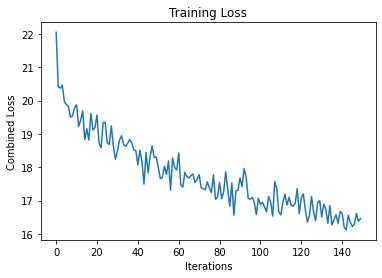

In [36]:
##Code class inherited from Dr. Kak's DL studio code

##  semantic_segmentation.py

"""
This script should be your starting point if you wish to learn how to use the
mUnet neural network for semantic segmentation of images.  As mentioned elsewhere in
the main documentation page, mUnet assigns an output channel to each different type of
object that you wish to segment out from an image. So, given a test image at the
input to the network, all you have to do is to examine each channel at the output for
segmenting out the objects that correspond to that output channel.
"""


"""
seed = 0           
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)
"""


##  watch -d -n 0.5 nvidia-smi

from DLStudio import *

dls = DLStudio(

                  dataroot = "/home/skose/dataset/",
                  image_size = [64,64],
                  path_saved_model = "./saved_model_combined",
                  momentum = 0.9,
                  learning_rate = 1e-4,
                  epochs = 6,
                  batch_size = 4,
                  classes = ('rectangle','triangle','disk','oval','star'),
                  use_gpu = True,
              )

segmenter = SemanticSegmentationCombined( 
                  dl_studio = dls, 
                  max_num_objects = 5,
              )

dataserver_train = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                          train_or_test = 'train',
                          dl_studio = dls,
                          segmenter = segmenter,
                          dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = DLStudio.SemanticSegmentation.PurdueShapes5MultiObjectDataset(
                          train_or_test = 'test',
                          dl_studio = dls,
                          segmenter = segmenter,
                          dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test

segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

model = segmenter.mUnet(skip_connections=True, depth=16)
#model = segmenter.mUnet(skip_connections=False, depth=4)

number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d\n" % number_of_learnable_params)

num_layers = len(list(model.parameters()))
print("\nThe number of layers in the model: %d\n\n" % num_layers)


combined_loss = segmenter.run_code_for_training_for_semantic_segmentation(model)




Loading training data from torch saved file




Showing output for test batch 1: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


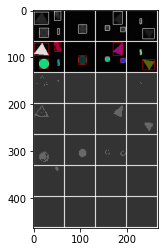





Showing output for test batch 51: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


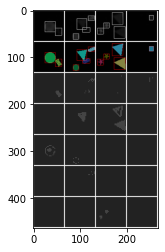





Showing output for test batch 101: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


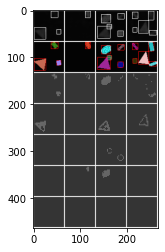





Showing output for test batch 151: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


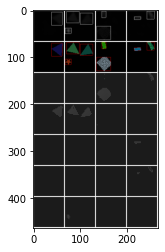





Showing output for test batch 201: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


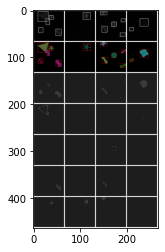

In [44]:
segmenter.run_code_for_testing_semantic_segmentation(model)

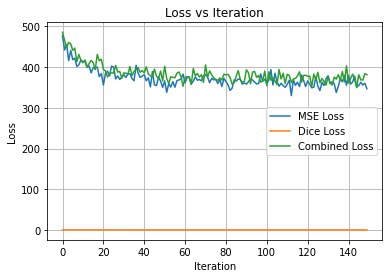

In [18]:
plt.plot(mse_loss, label='MSE Loss')
plt.plot(dice_loss, label='Dice Loss')
plt.plot(combined_loss, label='Combined Loss')
plt.title('Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()